In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, get_T_inds, make_dendro

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig4','lesion_effects')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

# parse input arguments as:
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-7)
seed = str(1)
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final'

# m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

model = FixedPoint_Model(m)
hp = model.hp

Overwrite sigma_rec with 0.000


/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


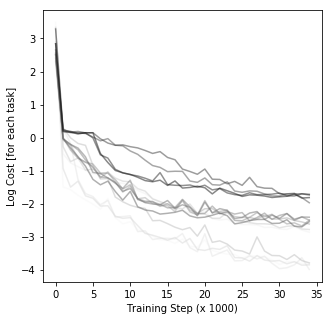

In [4]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

task_list = rule_trains

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
#     plt.ylim([-6,2])
    
# plt.title(m)
plt.show()    

In [5]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


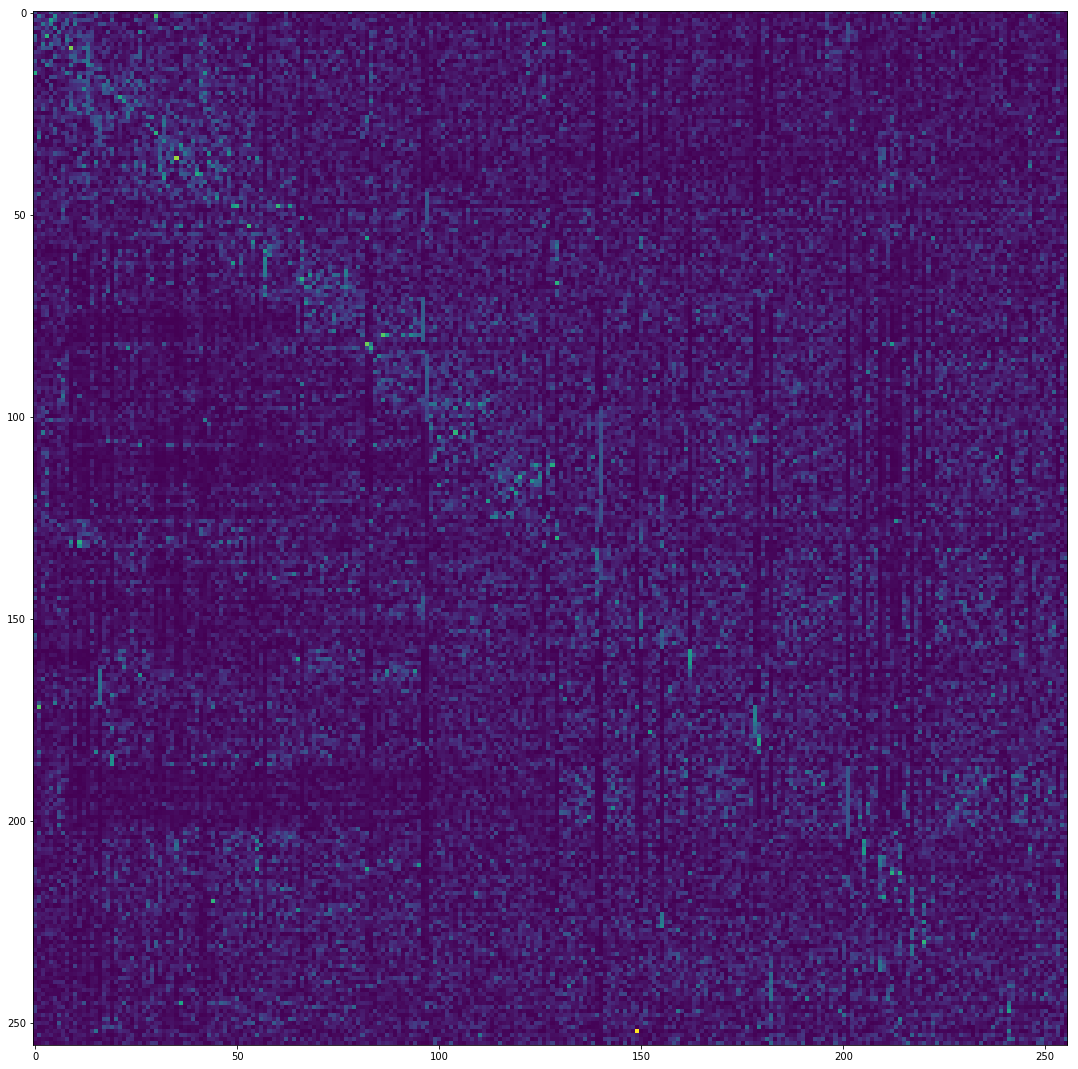

In [10]:
fig = plt.figure(figsize=(15,15),tight_layout=True,facecolor='white')
plt.imshow(abs(R))

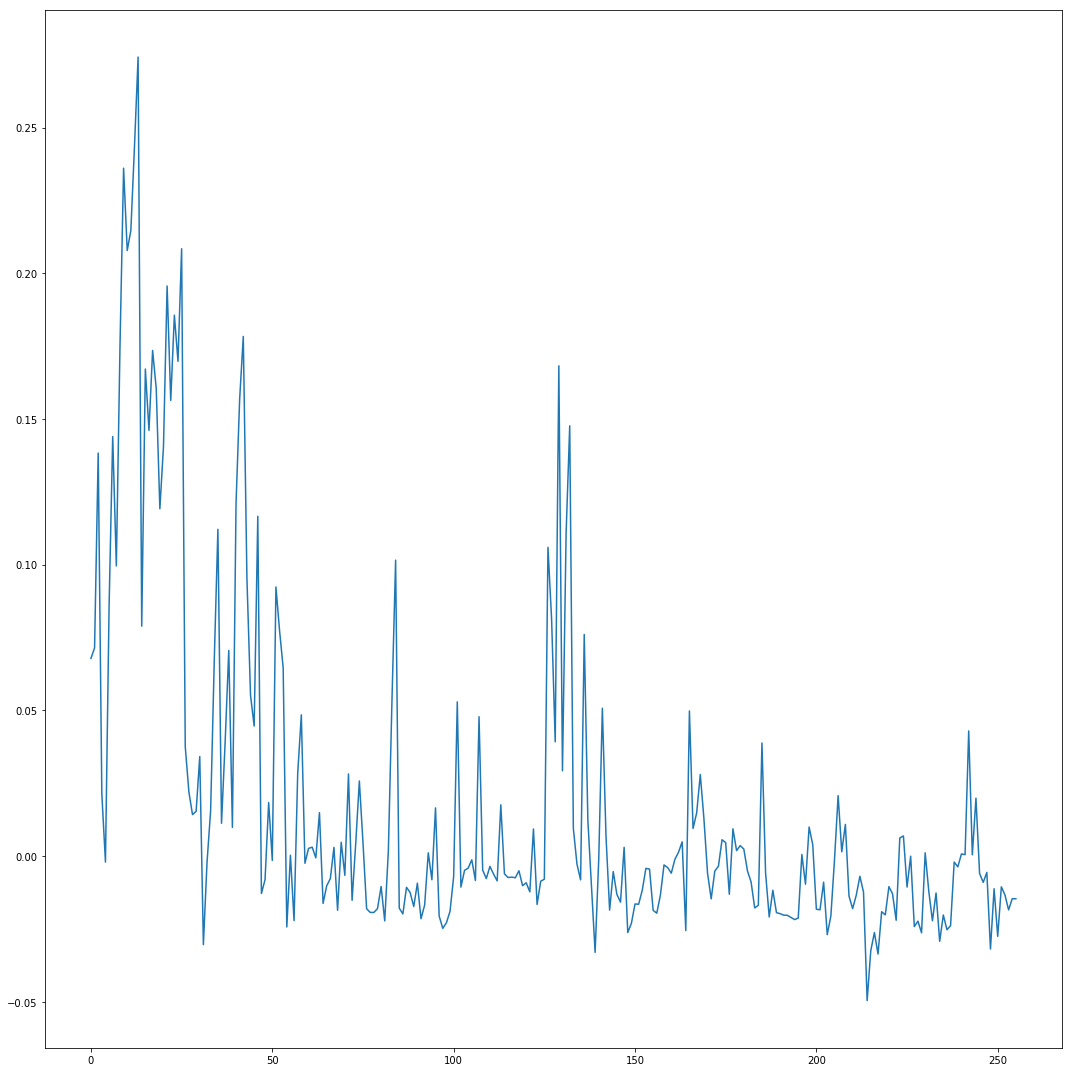

In [22]:
fig = plt.figure(figsize=(15,15),tight_layout=True,facecolor='white')
plt.plot(R[:,13])

In [19]:
cluster_var['lesion_units_list']

array([None, array([ 30, 227, 163, 100, 135, 113, 229,  27,  31]),
       array([142,  60, 132, 128, 107, 145,  14, 120, 252, 110, 118,  62, 161,
       211, 169,  69, 180]),
       array([ 59,  99,  68, 104, 134, 111, 119,  45, 253, 235,  38, 232, 222,
       177, 199, 125, 192,  10]),
       array([ 37,  61, 216, 190,  17, 200, 228, 164, 152, 130, 239, 122]),
       array([149, 197, 146, 138, 245,  98, 223,  87, 170,   3,  18, 123,  71,
         9,  85]),
       array([207, 117,  39,  41,  25, 220,  32, 203, 173,  64, 204, 212,  58,
       193,  52, 189, 185, 209, 255, 159,   7,  96,  86, 114,   4, 121,
       115, 241,  28, 116, 208]),
       array([ 51,   2,  55, 249,  44,   1,  12, 108, 188, 240,  75,  94,  13,
       221, 165, 157,  92, 217,  72, 140, 153,  97, 156, 225]),
       array([ 43, 247, 127, 131,  20,  42, 195]),
       array([174, 133, 231, 139, 141, 224, 147, 244, 226, 214,  40,  24, 103,
        63,  35,  11,  36,  57,  46,   5, 198, 243,  95, 137, 230]),
       arra

In [6]:
method = 'ward'
cel_max_d = 3.5
criterion = 'distance'
n_comps = 20

lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
save_dir = os.path.join(m,lesion_folder)
varimax_var = np.load(os.path.join(save_dir,'rotate_D_var.npz'))
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))

R = varimax_var['R']
lesion = R[:,13]


In [8]:
# Use customized session that launches the graph as well
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


In [40]:
n_input = hparams['n_input']
n_rnn = hparams['n_rnn']
n_output = hparams['n_output']
w_in = params[0]
b_in = params[1]
w_out = params[2]
b_out = params[3]
sigma_rec = hparams['sigma_rec']
dt = hparams['dt']
tau = hparams['tau']
alpha = dt/tau
activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def rnn_vanilla_lesion(params, h, x, alpha, lesion = []):
    alpha = .2
        
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output

    if len(lesion)==0:
        h_comp = h_new
    else:    
        xTh = np.dot(lesion[:,np.newaxis].T,h_new[:,np.newaxis])
        xThx = np.squeeze(np.dot(lesion[:,np.newaxis],xTh))
        h_comp = h_new - xThx
    
    return np.squeeze(h_comp)

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_with_h0_lesion(params, x_t, h0, alpha, lesion):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla_lesion(params, np.squeeze(h), np.squeeze(x.T), alpha, lesion = lesion)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

In [24]:
from tools_lnd import gen_trials_from_model_dir, gen_X_from_model_dir

rule = 'reactgo'
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
B = np.shape(trial.x)[1]
T = np.shape(trial.x)[0]
N = hparams['n_rnn']

_,h = gen_X_from_model_dir(m,trial)
init_ind = 0

y_hat = np.zeros((T,B,3))
for ti in range(B):

    h0 = h[:,ti,init_ind]
    x_t = trial.x[1:,ti,:]
    h_t = vanilla_run_with_h0_lesion(params, x_t, h0, hparams, lesion)
    y_hat[:,ti,:] = out_affine(params, h_t.T).T

y_loc = trial.y_loc[T_inds,:]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)
(25,) (256,)

NameError: name 'T_inds' is not defined

In [41]:
from tools_lnd import gen_trials_from_model_dir, gen_X_from_model_dir

rule = 'delaygo'
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
B = np.shape(trial.x)[1]
T = np.shape(trial.x)[0]
N = hparams['n_rnn']

_,h = gen_X_from_model_dir(m,trial)
init_ind = 0

y_hat = np.zeros((T,B,3))
for ti in range(B):

    h0 = h[:,ti,init_ind]
    x_t = trial.x[1:,ti,:]
    h_t = vanilla_run_with_h0_lesion(params, x_t, h0, hparams, np.squeeze(lesion))
    y_hat[:,ti,:] = out_affine(params, h_t.T).T

# y_loc = trial.y_loc[T_inds,:]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281

In [34]:
np.shape(trial.y_loc)

(125, 80)

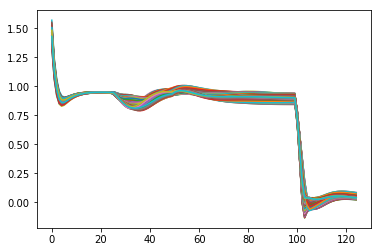

In [35]:
plt.plot(y_hat[:,:,0])
plt.show()

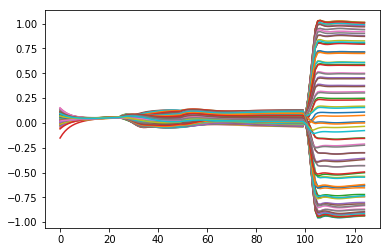

In [42]:
plt.plot(y_hat[:,:,1])
plt.show()

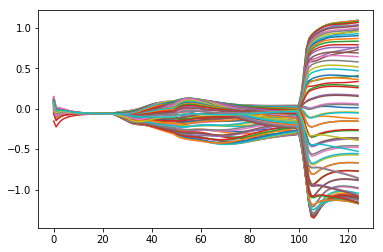

In [36]:
plt.plot(y_hat[:,:,1])
plt.show()

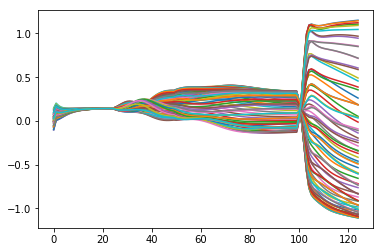

In [37]:
plt.plot(y_hat[:,:,2])
plt.show()

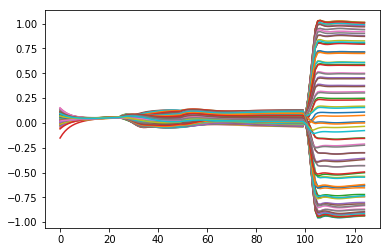

In [43]:
plt.plot(y_hat[:,:,1])
plt.show()

In [53]:
cmap=plt.get_cmap('rainbow')

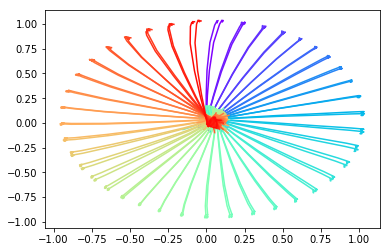

In [54]:
for x in range(80):
    plt.plot(y_hat[:,x,1],y_hat[:,x,2],color = cmap(x/80))
plt.show()